In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from imblearn.under_sampling import RandomUnderSampler #undersampler
from collections import Counter
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
df = pd.read_csv("df.csv")


In [2]:
X = df.drop(['dangerous'],axis = 1)
y = df['dangerous']

In [3]:
print(X)

         seconds    speed  date_of_birth  years_of_experience  gender  \
0            3.0   0.2284           1970                    9       0   
1            9.0   0.2284           1970                    9       0   
2           11.0   0.2284           1970                    9       0   
3           12.0   0.2284           1970                    9       0   
4           14.0   0.2284           1970                    9       0   
...          ...      ...            ...                  ...     ...   
7126682    395.0  14.9800           1981                   21       0   
7126683    400.0  14.2900           1981                   21       0   
7126684    401.0  14.0800           1981                   21       0   
7126685    402.0  13.8900           1981                   21       0   
7126686    403.0  13.5800           1981                   21       0   

         car_brand  car_model_year  driver_rating  magnitude_acceleration  
0                7            2003            4

Standardization of X


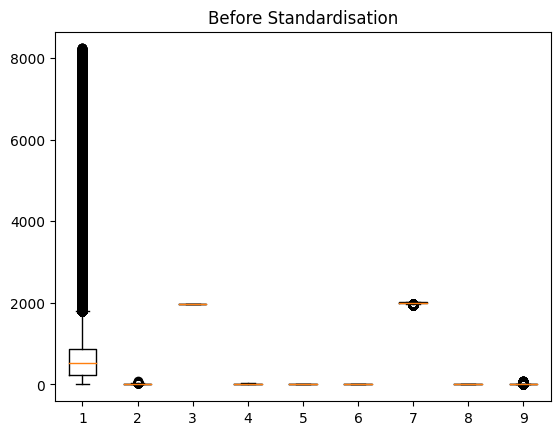

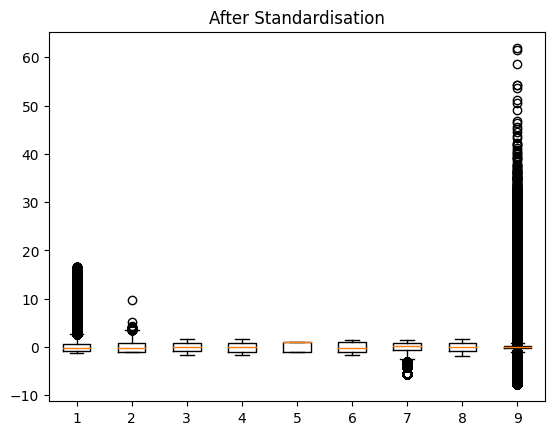

In [4]:
#function StandardScaler before and after
def aftstd(data):
    std_scaler = StandardScaler()
    df_std = std_scaler.fit(data)
    df_std = df_std.transform(data)
    plt.boxplot(df_std)
    plt.title('After Standardisation')
    plt.show()
    return df_std

def befstd(data):
    plt.boxplot(data)
    plt.title('Before Standardisation')
    plt.show()



to_standardize = X

print("Standardization of X")
#Before standardization
befstd(to_standardize)
# standardization
X = pd.DataFrame(aftstd(to_standardize))




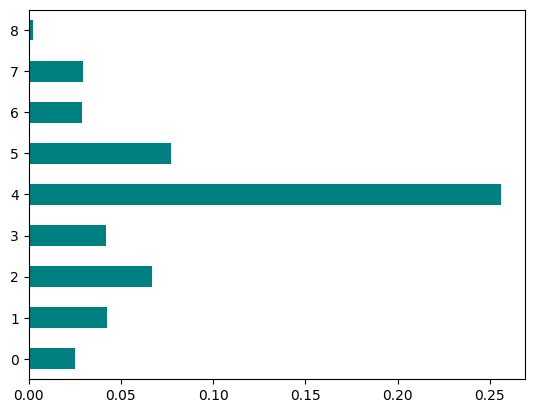


 Values that hits critera: 0.05

[2, 4, 5]


In [5]:
#Using feature selector (mutual info classifier) to find relevant data for the target
importances = mutual_info_classif(X,y)
feat_importances = pd.Series(importances, X.columns[0:len(X.columns)])
feat_importances.plot(kind="barh", color = "teal")
plt.show()

#creating new df importances
column_names = X.columns.values.tolist()
importances_values = importances.tolist()
df_importances = pd.DataFrame([importances_values], columns = column_names)


#Finding values that hits set criteria
criteria = 0.05
relevant = []
for i in df_importances:
    value = df_importances[i]
    if df_importances[i].values > criteria:
        relevant.append(i) 
        
print(f'\n Values that hits critera: {criteria}\n\n{relevant}')



In [6]:
#Updating X values
X_sorted = X[relevant].values
print(f'\nNew X values: \n\n{X_sorted}')


New X values: 

[[-1.64839788 -1.02549896  0.39718135]
 [-1.64839788 -1.02549896  0.39718135]
 [-1.64839788 -1.02549896  0.39718135]
 ...
 [ 1.3780974  -1.02549896 -1.56169553]
 [ 1.3780974  -1.02549896 -1.56169553]
 [ 1.3780974  -1.02549896 -1.56169553]]


In [7]:
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, train_size=0.75, random_state=102)

In [8]:
# Outlier Handling
print('Initial shape of the training dataset', X_train.shape, y_train.shape)
# identify outliers in the training dataset
iso = IsolationForest(contamination=0.1)
x_out = iso.fit_predict(X_train)
# select all rows that are not outliers
mask = (x_out != -1)
X_train, y_train = X_train.iloc[mask, :], y_train.iloc[mask]
# summarize the shape of the updated training dataset
print('Shape of the training dataset after removing outliers', X_train.shape, y_train.shape)

Initial shape of the training dataset (3243961, 9) (3243961,)
Shape of the training dataset after removing outliers (2919565, 9) (2919565,)


In [9]:
# Outlier Handling
print('Initial shape of the training dataset', X_train.shape, y_train.shape)
# identify outliers in the training dataset
lof = LocalOutlierFactor(contamination=0.1)
x_out = lof.fit_predict(X_train)
# select all rows that are not outliers
mask = (x_out != -1)
X_train, y_train = X_train.iloc[mask, :], y_train.iloc[mask]
# summarize the shape of the updated training dataset
print('Shape of the training dataset after removing outliers', X_train.shape, y_train.shape)

Initial shape of the training dataset (2919565, 9) (2919565,)
Shape of the training dataset after removing outliers (2627608, 9) (2627608,)


Tuned logreg param: {'tol': 0.4849, 'C': 0.38181818181818183}
Tuned logreg Best Accuracy Score: 0.46753668361829975


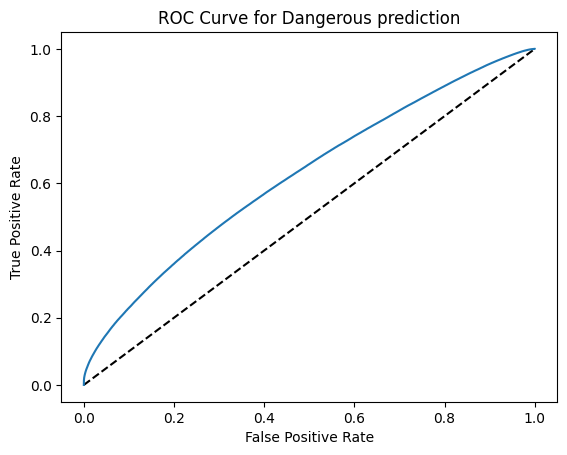


Accuracy score: 0.585773327254349

Classification report: 
              precision    recall  f1-score   support

           0       0.57      0.66      0.62    539973
           1       0.60      0.51      0.55    541348

    accuracy                           0.59   1081321
   macro avg       0.59      0.59      0.58   1081321
weighted avg       0.59      0.59      0.58   1081321


Confusion matrix: 
[[357999 181974]
 [265938 275410]]

ROC accuracy score: 0.6228730810167222


In [10]:
#Model used: Logistic regression
from sklearn.linear_model import LogisticRegression
import numpy as np

with mlflow.start_run():
    logisticregression = LogisticRegression(max_iter=1000)

    #Defining Kfold()
    kf = KFold(n_splits = 6, random_state=42, shuffle = True)


    #Using RandomizedSearchCV to tune hyperparameters and find best param 
    param_logreg = {
             "tol": np.linspace(0.0001, 1.0, 100),
             "C": np.linspace(0.1, 1.0, 100)
    }
    logreg_cv = RandomizedSearchCV(logisticregression,param_logreg,cv=kf,scoring='recall')
    logreg_cv.fit(X_train,y_train)
    print("Tuned logreg param: {}".format(logreg_cv.best_params_))
    print("Tuned logreg Best Accuracy Score: {}".format(logreg_cv.best_score_))

    #Predicting X_test
    y_hat = logreg_cv.predict(X_test)




    #ROC Curve
    y_pred_probs = logreg_cv.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Dangerous prediction')
    plt.show()

    #Results
    print(f'\nAccuracy score: {accuracy_score(y_test,y_hat)}')
    print(f'\nClassification report: \n{classification_report(y_test,y_hat)}')
    print(f'\nConfusion matrix: \n{confusion_matrix(y_test,y_hat)}')
    print(f'\nROC accuracy score: {roc_auc_score(y_test, y_pred_probs)}')
    mlflow.sklearn.log_model(logreg_cv, 'Logistic Regression Model')

In [12]:
batch_size = 1000
num_batches = len(X_train) // batch_size + 1

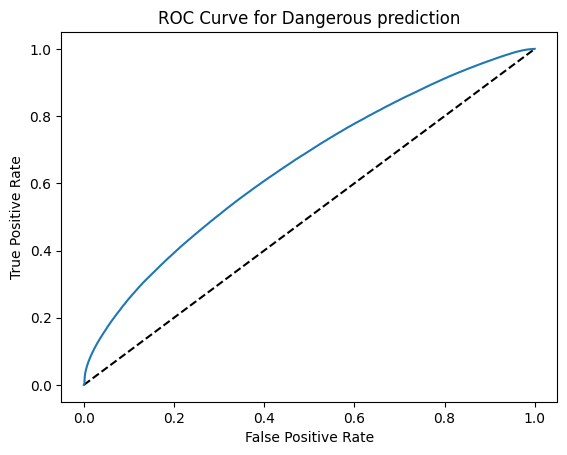


Accuracy score: 0.6042988159852625

Classification report: 
              precision    recall  f1-score   support

           0       0.60      0.65      0.62    539973
           1       0.62      0.56      0.59    541348

    accuracy                           0.60   1081321
   macro avg       0.61      0.60      0.60   1081321
weighted avg       0.61      0.60      0.60   1081321


Confusion matrix: 
[[350877 189096]
 [238784 302564]]

ROC accuracy score: 0.6506435334590684


In [13]:
#Model used: MLPClassifier
from sklearn.neural_network import MLPClassifier
mlpclassifier = MLPClassifier(activation='relu',solver='adam',alpha=0.0001,max_iter=1000)



for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(X_train))
    X_batch = X_train[start_idx:end_idx]
    y_batch = y_train[start_idx:end_idx]
    mlpclassifier.partial_fit(X_batch, y_batch, classes=np.unique(y_train))
    
# print("Tuned logreg param: {}".format(mlpclass_cv.best_params_))
# print("Tuned logreg Best Accuracy Score: {}".format(mlpclass_cv.best_score_))

#Predicting X_test
y_hat = mlpclassifier.predict(X_test)


#ROC Curve
y_pred_probs = mlpclassifier.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Dangerous prediction')
plt.show()

#accuracy score 
print(f'\nAccuracy score: {accuracy_score(y_test,y_hat)}')
print(f'\nClassification report: \n{classification_report(y_test,y_hat)}')
print(f'\nConfusion matrix: \n{confusion_matrix(y_test,y_hat)}')
print(f'\nROC accuracy score: {roc_auc_score(y_test, y_pred_probs)}')

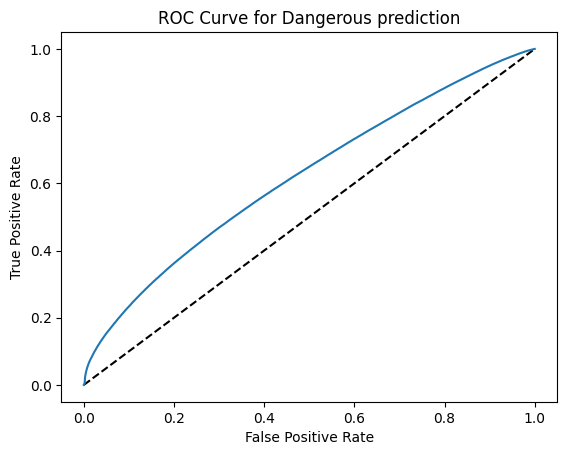


Accuracy score: 0.5831126927156691

Classification report: 
              precision    recall  f1-score   support

           0       0.56      0.75      0.64    539973
           1       0.62      0.42      0.50    541348

    accuracy                           0.58   1081321
   macro avg       0.59      0.58      0.57   1081321
weighted avg       0.59      0.58      0.57   1081321


Confusion matrix: 
[[403026 136947]
 [313842 227506]]

ROC accuracy score: 0.6188973473598156


In [15]:
#Model used: Naive Bayes
from sklearn.naive_bayes import GaussianNB
gaussianNB = GaussianNB()


for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(X_train))
    X_batch = X_train[start_idx:end_idx]
    y_batch = y_train[start_idx:end_idx]
    gaussianNB.partial_fit(X_batch, y_batch, classes=np.unique(y_train))

#Predicting X_test
y_hat = gaussianNB.predict(X_test)

#ROC Curve
y_pred_probs = gaussianNB.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Dangerous prediction')
plt.show()

#accuracy score 
print(f'\nAccuracy score: {accuracy_score(y_test,y_hat)}')
print(f'\nClassification report: \n{classification_report(y_test,y_hat)}')
print(f'\nConfusion matrix: \n{confusion_matrix(y_test,y_hat)}')
print(f'\nROC accuracy score: {roc_auc_score(y_test, y_pred_probs)}')

In [ ]:
with mlflow.start_run():
    logisticregression = LogisticRegression(max_iter=1000)

    #Defining Kfold()
    kf = KFold(n_splits = 6, random_state=42, shuffle = True)


    #Using RandomizedSearchCV to tune hyperparameters and find best param 
    param_logreg = {
             "tol": np.linspace(0.0001, 1.0, 100),
             "C": np.linspace(0.1, 1.0, 100)
    }
    logreg_cv = RandomizedSearchCV(logisticregression,param_logreg,cv=kf,scoring='recall')
    logreg_cv.fit(X_train,y_train)
    print("Tuned logreg param: {}".format(logreg_cv.best_params_))
    print("Tuned logreg Best Accuracy Score: {}".format(logreg_cv.best_score_))

    #Predicting X_test
    y_hat = logreg_cv.predict(X_test)




    #ROC Curve
    y_pred_probs = logreg_cv.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Dangerous prediction')
    plt.show()

    #Results
    print(f'\nAccuracy score: {accuracy_score(y_test,y_hat)}')
    print(f'\nClassification report: \n{classification_report(y_test,y_hat)}')
    print(f'\nConfusion matrix: \n{confusion_matrix(y_test,y_hat)}')
    print(f'\nROC accuracy score: {roc_auc_score(y_test, y_pred_probs)}')
    mlflow.sklearn.log_model(logreg_cv, 'Logistic Regression Model')

In [ ]:
with mlflow.start_run():
    #Model used: MLPClassifier
    mlpclassifier = MLPClassifier(activation='relu',solver='adam',alpha=0.0001,max_iter=1000)



    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(X_train))
        X_batch = X_train[start_idx:end_idx]
        y_batch = y_train[start_idx:end_idx]
        mlpclassifier.partial_fit(X_batch, y_batch, classes=np.unique(y_train))
        
    # print("Tuned logreg param: {}".format(mlpclass_cv.best_params_))
    # print("Tuned logreg Best Accuracy Score: {}".format(mlpclass_cv.best_score_))

    #Predicting X_test
    y_hat = mlpclassifier.predict(X_test)


    #ROC Curve
    y_pred_probs = mlpclassifier.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Dangerous prediction')
    plt.show()

    #accuracy score 
    print(f'\nAccuracy score: {accuracy_score(y_test,y_hat)}')
    print(f'\nClassification report: \n{classification_report(y_test,y_hat)}')
    print(f'\nConfusion matrix: \n{confusion_matrix(y_test,y_hat)}')
    print(f'\nROC accuracy score: {roc_auc_score(y_test, y_pred_probs)}')
    mlflow.sklearn.log_model(mlpclassifier, 'MLP Classifier Model')

In [ ]:
with mlflow.start_run():
    #Model used: Naive Bayes
    gaussianNB = GaussianNB()


    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(X_train))
        X_batch = X_train[start_idx:end_idx]
        y_batch = y_train[start_idx:end_idx]
        gaussianNB.partial_fit(X_batch, y_batch, classes=np.unique(y_train))

    #Predicting X_test
    y_hat = gaussianNB.predict(X_test)

    #ROC Curve
    y_pred_probs = gaussianNB.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Dangerous prediction')
    plt.show()

    #accuracy score 
    print(f'\nAccuracy score: {accuracy_score(y_test,y_hat)}')
    print(f'\nClassification report: \n{classification_report(y_test,y_hat)}')
    print(f'\nConfusion matrix: \n{confusion_matrix(y_test,y_hat)}')
    print(f'\nROC accuracy score: {roc_auc_score(y_test, y_pred_probs)}')
    mlflow.sklearn.log_model(gaussianNB, 'Gaussian Naive Bayes')

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# rfc = RandomForestClassifier(n_estimators=100, random_state=42)
# rfc.fit(X_train, y_train)

# #Predicting X_test
# for i in range(num_batches):
#     start_idx = i * batch_size
#     end_idx = min((i + 1) * batch_size, len(X_train))
#     X_batch = X_train[start_idx:end_idx]
#     y_batch = y_train[start_idx:end_idx]
    
#     # Fit the model to the current batch
#     if i == 0:
#         rfc.fit(X_batch, y_batch)
#     else:
#         rfc.n_estimators += 100  # Increase the number of estimators
#         rfc.fit(X_batch, y_batch)
        
# #ROC Curve
# y_pred_probs = rfc.predict_proba(X_test)[:, 1]
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr, tpr)
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve for Dangerous prediction')
# plt.show()

# #accuracy score 
# print(f'\nAccuracy score: {accuracy_score(y_test,y_hat)}')
# print(f'\nClassification report: \n{classification_report(y_test,y_hat)}')
# print(f'\nConfusion matrix: \n{confusion_matrix(y_test,y_hat)}')
# print(f'\nROC accuracy score: {roc_auc_score(y_test, y_pred_probs)}')




In [ ]:
# #Model used: Support vector classifier
# from sklearn.svm import SVC
# svc = SVC()

# #Defining Kfold()
# kf = KFold(n_splits = 6, random_state=42, shuffle = True)


# #Using RandomizedSearchCV to tune hyperparameters and find best param 
# param_svc = {
#          "C": np.linspace(0.1, 1.0, 100)
# }
# param_svc['probability'] = [True]
# svc_cv = RandomizedSearchCV(svc,param_svc,cv=kf,scoring='accuracy')
# svc_cv.fit(X_train,y_train)
# print("Tuned logreg param: {}".format(svc_cv.best_params_))
# print("Tuned logreg Best Accuracy Score: {}".format(svc_cv.best_score_))

# #Predicting X_test
# y_hat = svc_cv.predict(X_test)

# #ROC Curve
# y_pred_probs = svc_cv.predict_proba(X_test)[:, 1]
# fpr, tpr, thresholds = roc_curve(ytest, y_pred_probs)
# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr, tpr)
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve for Dangerous prediction')
# plt.show()

# #accuracy score 
# print(f'\nAccuracy score: {accuracy_score(ytest,y_hat)}')
# print(f'\nClassification report: \n{classification_report(ytest,y_hat)}')
# print(f'\nConfusion matrix: \n{confusion_matrix(ytest,y_hat)}')
# print(f'\nROC accuracy score: {roc_auc_score(ytest, y_pred_probs)}')

In [ ]:
# #Model used: gradient boosting classifier
# import numpy as np
# from sklearn.ensemble import GradientBoostingClassifier


# hyperparameters = {
#     'n_estimators': 100,
#     'learning_rate': 0.001,
#     'max_depth': 3,  
#     'min_samples_split': 2,  
#     'min_samples_leaf': 1,  
#     'subsample': 1.0  
# }

# gbc = GradientBoostingClassifier(**hyperparameters)

# for i in range(num_batches):
#     start_idx = i * batch_size
#     end_idx = min((i + 1) * batch_size, len(X_train))
#     X_batch = X_train[start_idx:end_idx]
#     y_batch = y_train[start_idx:end_idx]
#     gbc.partial_fit(X_batch, y_batch, classes=np.unique(y_train))
    

# #Predicting X_test
# y_hat = gbc.predict(X_test)

# #ROC Curve
# y_pred_probs = gbc.predict_proba(X_test)[:, 1]
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr, tpr)
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve for Dangerous prediction')
# plt.show()

# #accuracy score 
# print(f'\nAccuracy score: {accuracy_score(y_test,y_hat)}')
# print(f'\nClassification report: \n{classification_report(y_test,y_hat)}')
# print(f'\nConfusion matrix: \n{confusion_matrix(y_test,y_hat)}')
# print(f'\nROC accuracy score: {roc_auc_score(y_test, y_pred_probs)}')